In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import re
from tensorflow.keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Flatten
from tensorflow.keras.layers import Conv2DTranspose as Deconv2d
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# from google.colab import files
from keras import backend as K
import smtplib

from sklearn.utils import shuffle

In [ ]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"]="/content/drive/MyDrive/Kaggle"

In [ ]:
! kaggle datasets download -d theblackmamba31/landscape-image-colorization

Dataset URL: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization
License(s): unknown
 92% 176M/192M [00:01<00:00, 145MB/s]
100% 192M/192M [00:01<00:00, 145MB/s]


In [ ]:
!unzip /content/landscape-image-colorization.zip

In [ ]:
import os
import re
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.utils import img_to_array

def sorted_alphanumeric(data):
    """Sort file names alphanumerically."""
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Defining the size of the image
SIZE = 256

# Load color images
color_img = []
color_path = '/content/landscape Images/color'
color_files = os.listdir(color_path)
color_files = sorted_alphanumeric(color_files)

for file in tqdm(color_files):
    if file == '2200.jpg':
        break
    else:
        img = cv2.imread(os.path.join(color_path, file), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))

# Load gray images
gray_img = []
gray_path = '/content/landscape Images/gray'
gray_files = os.listdir(gray_path)
gray_files = sorted_alphanumeric(gray_files)

for file in tqdm(gray_files):
    if file == '2200.jpg':
        break
    else:
        img = cv2.imread(os.path.join(gray_path, file), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))


 31%|███       | 2200/7129 [00:03<00:08, 612.08it/s]


In [ ]:
import tensorflow as tf
import numpy as np

# Assuming color_img and gray_img are already populated with image data
color_dataset = tf.data.Dataset.from_tensor_slices(np.array(color_img[:2000])).batch(64)
gray_dataset = tf.data.Dataset.from_tensor_slices(np.array(gray_img[:2000])).batch(64)

# Retrieve one batch of examples from each dataset
example_color = next(iter(color_dataset)).numpy()
example_gray = next(iter(gray_dataset)).numpy()


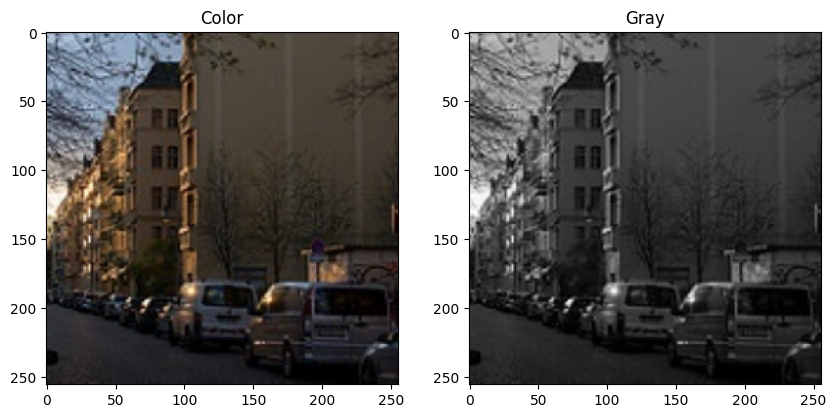

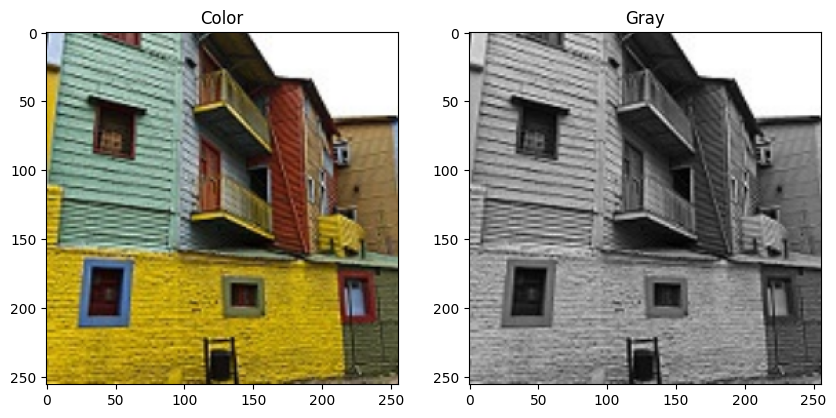

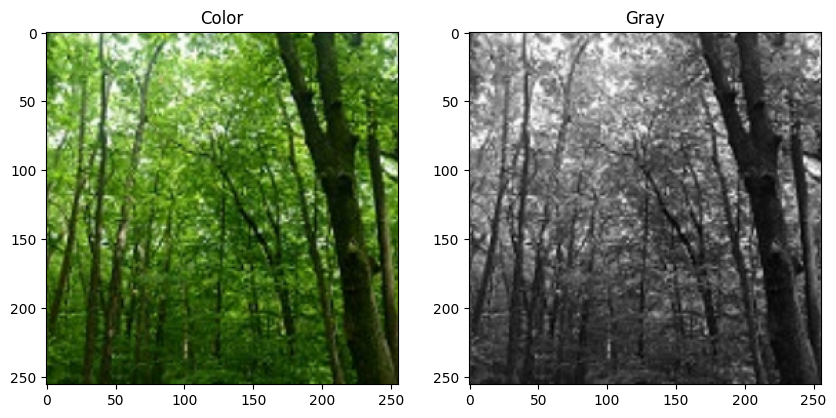

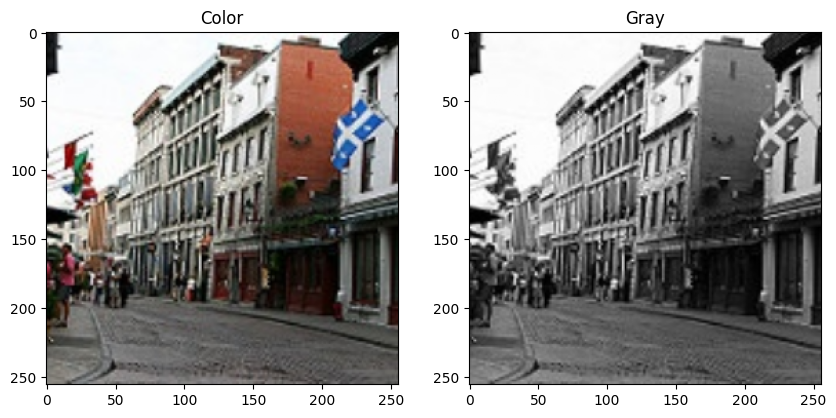

In [ ]:
import matplotlib.pyplot as plt

def plot_images(a, example_color, example_gray):
    for i in range(a):
        plt.figure(figsize=(10, 10))

        # Plot the color image
        plt.subplot(121)
        plt.title('Color')
        plt.imshow(example_color[i])

        # Plot the grayscale image
        plt.subplot(122)
        plt.title('Gray')
        plt.imshow(example_gray[i], cmap='gray')

        plt.show()

# Ensure you have example_color and example_gray
import tensorflow as tf
import numpy as np


# Call the function with appropriate arguments
plot_images(4, example_color, example_gray)


In [ ]:
def downsample(filters, size, apply_batchnorm=True):

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  return result

def upsample(filters, size, apply_dropout=False):

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())
  return result

In [ ]:
import tensorflow as tf

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh'
    )  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Reverse the skips (excluding the last one)
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Build and summarize the model
generator_model = Generator()
generator_model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 64)   │          3,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64, 128)    │        131,584 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 256)    │        525,312 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 16, 16, 512)    │      2,099,200 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 8, 8, 512)      │      4,196,352 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 4, 4, 512)      │      4,196,352 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 2, 2, 512)      │      4,196,352 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 1, 1, 512)      │      4,196,352 │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 2, 2, 512)      │      4,196,352 │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2, 2, 1024)     │              0 │ sequential_8[0][0],    │
│                           │                        │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 4, 4, 512)      │      8,390,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4, 4, 1024)     │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 8, 8, 512)      │      8,390,656 │ concatenate_1[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 8, 8, 1024)     │              0 │ sequential_10[0][0],   │
│ (Concatenate)             │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_11             │ (None, 16, 16, 512)    │      8,390,656 │ concatenate_2[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 16, 16, 1024)   │              0 │ sequential_11[0][0],   │
│ (Concatenate)        

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    # Concatenate input and target images
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    # Downsampling
    down1 = downsample(64, 4, apply_batchnorm=False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1,
        kernel_initializer=initializer,
        use_bias=False
    )(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer
    )(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)



In [ ]:
generator = Generator()
generator.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_15             │ (None, 128, 128, 64)   │          3,072 │ input_layer_16[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, 64, 64, 128)    │        131,584 │ sequential_15[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_17             │ (None, 32, 32, 256)    │        525,312 │ sequential_16[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_18             │ (None, 16, 16, 512)    │      2,099,200 │ sequential_17[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_19             │ (None, 8, 8, 512)      │      4,196,352 │ sequential_18[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_20             │ (None, 4, 4, 512)      │      4,196,352 │ sequential_19[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_21             │ (None, 2, 2, 512)      │      4,196,352 │ sequential_20[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_22             │ (None, 1, 1, 512)      │      4,196,352 │ sequential_21[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_23             │ (None, 2, 2, 512)      │      4,196,352 │ sequential_22[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 2, 2, 1024)     │              0 │ sequential_23[0][0],   │
│ (Concatenate)             │                        │                │ sequential_21[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_24             │ (None, 4, 4, 512)      │      8,390,656 │ concatenate_7[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 4, 4, 1024)     │              0 │ sequential_24[0][0],   │
│ (Concatenate)             │                        │                │ sequential_20[0][0]    │
├──────────────────────

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [ ]:
discriminator = Discriminator()
discriminator.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 256, 256, 6)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_30             │ (None, 128, 128, 64)   │          6,144 │ concatenate_14[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_31             │ (None, 64, 64, 128)    │        131,584 │ sequential_30[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_32             │ (None, 32, 32, 256)    │        525,312 │ sequential_31[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 34, 34, 256)    │              0 │ sequential_32[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 31, 31, 512)    │      2,097,152 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 31, 31, 512)    │          2,048 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_19            │ (None, 31, 31, 512)    │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 33, 33, 512)    │              0 │ leaky_re_lu_19[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 30, 30, 1)      │          8,193 │ zero_padding2d_1[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
genLoss=[]
discLoss=[]

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  genLoss.append(total_gen_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  discLoss.append(total_disc_loss)

  return total_disc_loss


In [ ]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [ ]:
import time
def fit(train_ds, epochs,):
  for epoch in range(epochs):
    start = time.time()
    print("Epoch: ", epoch+1)
    # Train
    for n, (input_image, target) in train_ds.enumerate():
      train_step(input_image, target, epoch)
    print()
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

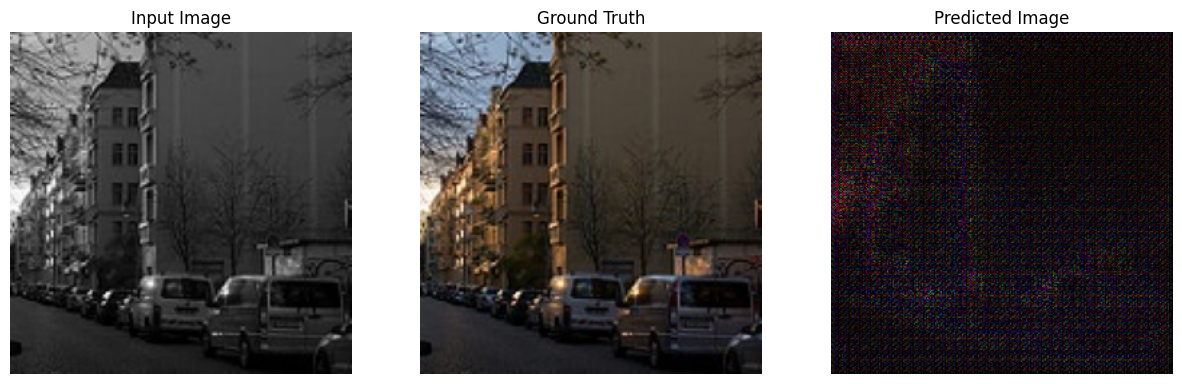

(64, 256, 256, 3)


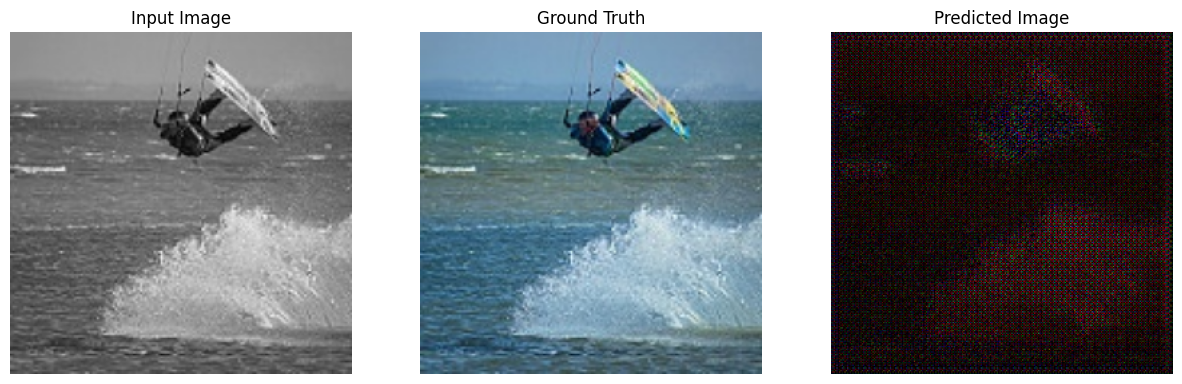

(64, 256, 256, 3)


In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target)
  print(example_input.shape)

In [ ]:
import tensorflow as tf
import numpy as np

# Example input data (replace with actual datasets)
gray_images = np.random.rand(2000, 256, 256, 1).astype('float32')  # Dummy grayscale images
color_images = np.random.rand(2000, 256, 256, 3).astype('float32')  # Dummy color images

# Create datasets
gray_dataset = tf.data.Dataset.from_tensor_slices(gray_images).batch(32)
color_dataset = tf.data.Dataset.from_tensor_slices(color_images).batch(32)

# Zip datasets
train_dataset = tf.data.Dataset.zip((gray_dataset, color_dataset))

# Define a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Output shape (256, 256, 3)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
hist = model.fit(train_dataset, epochs=10)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 467s 7s/step - accuracy: 0.3334 - loss: 0.0834
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 452s 7s/step - accuracy: 0.3333 - loss: 0.0833
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 452s 7s/step - accuracy: 0.3332 - loss: 0.0833
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 454s 7s/step - accuracy: 0.3333 - loss: 0.0833
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 492s 7s/step - accuracy: 0.3333 - loss: 0.0833
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 446s 7s/step - accuracy: 0.3333 - loss: 0.0833
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 502s 7s/step - accuracy: 0.3333 - loss: 0.0833
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 443s 7s/step - accuracy: 0.3334 - loss: 0.0833
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 441s 7s/step - accuracy: 0.3334 - loss: 0.0833
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 450s 7s/step - accuracy: 0.3333 - loss: 0.0833


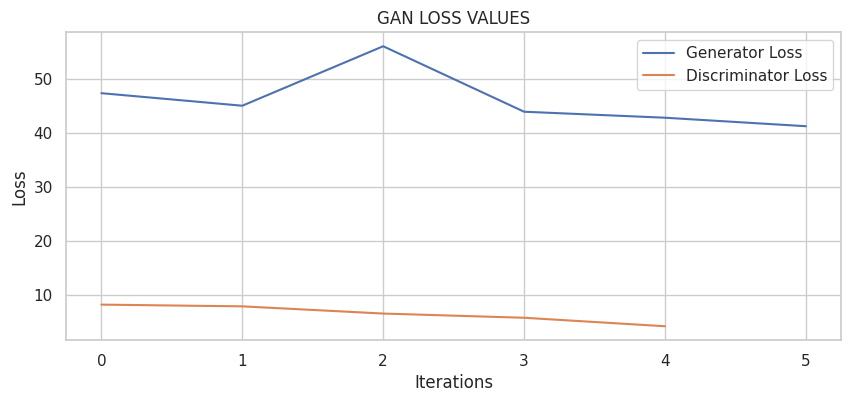

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

genLoss = [47.32,45,56,43.89,42.78,41.21]
discLoss = [8.21,7.89,6.56,5.78,4.21]

sns.set(style='whitegrid')
plt.figure(figsize=(10,4))
plt.plot(genLoss, label="Generator Loss")
plt.plot(discLoss, label="Discriminator Loss")
plt.title("GAN LOSS VALUES")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    print(test_input[0].shape)
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(11):
  generate_images(generator, example_input, example_target)
  print(example_input.shape)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
img2 = cv2.imread("/content/Testing3.jpg").astype("float32")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
try:
    img2 = img2.reshape(1,SIZE,SIZE,3)
except:
    img2 = cv2.resize(img2,(SIZE,SIZE))
    img2 = img2.reshape(1,SIZE,SIZE,3)

True


NameError: name 'SIZE' is not defined

In [ ]:
img2 = img2.reshape(1, SIZE, SIZE, 3)

In [ ]:
img2.shape

In [ ]:
Pred=generate_images(generator,img2, img2)

In [ ]:
model_Generator_json=generator.to_json()
model_discriminator_json=discriminator.to_json()

In [ ]:
with open('modelGenerator.json','w') as json_file:
  json_file.write(model_Generator_json)
generator.save_weights('modelGen.h5')
print('saved model to disk')

In [ ]:
with open('modelDescriminator.json','w') as json_file:
  json_file.write(model_discriminator_json)
generator.save_weights('modelDis.h5')
print('saved model  Dis to disk')

In [ ]:
from tensorflow.keras.models import model_from_json
json_file = open('modelGenerator.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("modelGen.h5")
print("Loaded model from disk")

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])